In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


def Conv2d(in_ch, out_ch, stride, kernel_size=3, padding=1):
        """Returns an instance of nn.Conv2d"""
        return nn.Conv2d(in_channels=in_ch, out_channels=out_ch,
                         stride=stride, kernel_size=kernel_size, padding=padding)


class LowLevelFeatures(nn.Module):
    """Low-Level Features Network"""

    def __init__(self, net_divisor=1):
        super(LowLevelFeatures, self).__init__()

        ksize = np.array([1, 64, 128, 128, 256, 256, 512]) // net_divisor
        ksize[0] = 1

        self.conv1 = Conv2d(1, ksize[1], 2)
        self.conv2 = Conv2d(ksize[1], ksize[2], 1)
        self.conv3 = Conv2d(ksize[2], ksize[3], 2)
        self.conv4 = Conv2d(ksize[3], ksize[4], 1)
        self.conv5 = Conv2d(ksize[4], ksize[5], 2)
        self.conv6 = Conv2d(ksize[5], ksize[6], 1)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        out = F.relu(self.conv6(out))
        return out


class MidLevelFeatures(nn.Module):
    """Mid-Level Features Network"""

    def __init__(self, net_divisor=1):
        super(MidLevelFeatures, self).__init__()

        ksize = np.array([512, 512, 256]) // net_divisor

        self.conv7 = Conv2d(ksize[0], ksize[1], 1)
        self.conv8 = Conv2d(ksize[1], ksize[2], 1)

    def forward(self, x):
        out = F.relu(self.conv7(x))
        out = F.relu(self.conv8(out))
        return out


class GlobalFeatures(nn.Module):
    """Global Features Network"""

    def __init__(self, net_divisor=1):
        super(GlobalFeatures, self).__init__()

        ksize = np.array([512, 1024, 512, 256]) // net_divisor
        self.ksize0 = ksize[0]

        self.conv1 = Conv2d(ksize[0], ksize[0], 2)
        self.conv2 = Conv2d(ksize[0], ksize[0], 1)
        self.conv3 = Conv2d(ksize[0], ksize[0], 2)
        self.conv4 = Conv2d(ksize[0], ksize[0], 1)
        self.fc1 = nn.Linear(7*7*ksize[0], ksize[1])
        self.fc2 = nn.Linear(ksize[1], ksize[2])
        self.fc3 = nn.Linear(ksize[2], ksize[3])

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        y = F.relu(self.conv4(y))
        y = y.view(-1, 7*7*self.ksize0)
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        
        # Branching
        out = y
        classification_in = y

        out = F.relu(self.fc3(out))

        return out, classification_in

class ColorizationNetwork(nn.Module):
    """Colorizaion Network"""

    def __init__(self, net_divisor=1):
        super(ColorizationNetwork, self).__init__()

        ksize = np.array([256, 128, 64, 64, 32]) // net_divisor

        self.conv9 = Conv2d(ksize[0], ksize[1], 1)
        
        # Here comes upsample #1
        
        self.conv10 = Conv2d(ksize[1], ksize[2], 1)
        self.conv11 = Conv2d(ksize[2], ksize[3], 1)
        
        # Here comes upsample #2        
        
        self.conv12 = Conv2d(ksize[3], ksize[4], 1)
        self.conv13 = Conv2d(ksize[4], 2, 1)
    
    def forward(self, x):
        out = F.relu(self.conv9(x))

        # Upsample #1        
        out = nn.functional.interpolate(input=out, scale_factor=2)

        out = F.relu(self.conv10(out))
        out = F.relu(self.conv11(out))
        
        # Upsample #2
        out = nn.functional.interpolate(input=out, scale_factor=2)

        out = F.relu(self.conv12(out))
        out = torch.sigmoid(self.conv13(out))
        
        # Upsample #3
        out = nn.functional.interpolate(input=out, scale_factor=2)
        
        return out


class ClassNet(nn.Module):
    """Classification Network Class"""

    def __init__(self, num_classes, net_divisor=1):
        super(ClassNet, self).__init__()
        
        self.num_classes = num_classes
        ksize = np.array([512, 256]) // net_divisor

        self.fc1 = nn.Linear(ksize[0], ksize[1])
        self.fc2 = nn.Linear(ksize[1], num_classes)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        return out





class ColNet(nn.Module):
    """Colorization network class"""

    def __init__(self, num_classes, net_divisor=1):
        """Initializes the network.
        Args:
            net_divisor - divisor of net output sizes. Useful for debugging.
        """
        super(ColNet, self).__init__()

        self.net_divisor = net_divisor

        self.conv_fuse = Conv2d(512 // net_divisor, 256 // net_divisor, 1, kernel_size=1, padding=0)

        self.low = LowLevelFeatures(net_divisor)
        self.mid = MidLevelFeatures(net_divisor)
        self.classifier = ClassNet(num_classes, net_divisor)
        self.glob = GlobalFeatures(net_divisor)
        self.col = ColorizationNetwork(net_divisor)



    def fusion_layer(self, mid_out, glob_out):
        h = mid_out.shape[2]  # Height of a picture  
        w = mid_out.shape[3]  # Width of a picture
        
        glob_stack2d = torch.stack(tuple(glob_out for _ in range(w)), 1)
        glob_stack3d = torch.stack(tuple(glob_stack2d for _ in range(h)), 1)
        glob_stack3d = glob_stack3d.permute(0, 3, 1, 2)

        # 'Merge' two volumes
        stack_volume = torch.cat((mid_out, glob_stack3d), 1)

        out = F.relu(self.conv_fuse(stack_volume))
        return out


    def forward(self, x):
        # Low level
        low_out = self.low(x)
        
        # Net branch         
        mid_out = low_out
        glob_out = low_out

        # Mid level
        mid_out = self.mid(mid_out)

        # Global
        glob_out, classification_in = self.glob(glob_out)

        # Classification
        classification_out = self.classifier(classification_in)

        # Fusion layer
        out = self.fusion_layer(mid_out, glob_out)

        # Colorization Net
        out = self.col(out)
        
        return out, classification_out

In [ ]:


import os
import torch
import numpy as np
import torchvision.datasets
import torchvision.transforms
from skimage import color, io
from random import randint


class HandleGrayscale(object):
    """Feeds the pipeline with 3 - channel image.
    
    All transformations below work with RGB images only.
    If a 1-channel grayscale image is given, it's converted to
    equivalent 3-channel RGB image.
    """
    def __call__(self, image):
        if len(image.shape) < 3:
            image = color.gray2rgb(image)
        return image


class RandomCrop(object):
    """Randomly crops an image to size x size."""
    
    def __init__(self, size=224):
        self.size = size
        
    def __call__(self, image):

        h, w, _ = image.shape
        assert min(h, w) >= self.size

        off_h = randint(0, h - self.size)
        off_w = randint(0, w - self.size)

        cropped = image[off_h:off_h+self.size, off_w:off_w+self.size]

        assert cropped.shape == (self.size, self.size, 3)
        return cropped

    
class Rgb2LabNorm(object):
    """Converts an RGB image to normalized image in LAB color sapce.
    
    Both (L, ab) channels are in [0, 1].
    """
    def __call__(self, image):
        assert image.shape == (224, 224, 3)
        img_lab = color.rgb2lab(image)
        img_lab[:,:,:1] = img_lab[:,:,:1] / 100.0
        img_lab[:,:,1:] = (img_lab[:,:,1:] + 128.0) / 256.0
        return img_lab
    
    
class ToTensor(object):
    """Converts an image to torch.Tensor.
    
    Note:
        Images are Height x Width x Channels format. 
        One needs to convert them to CxHxW.
    """
    def __call__(self, image):
        
        assert image.shape == (224, 224, 3)
        
        transposed =  np.transpose(image, (2, 0, 1)).astype(np.float32)
        image_tensor = torch.from_numpy(transposed)

        assert image_tensor.shape == (3, 224, 224)
        return image_tensor

    
class SplitLab(object):
    """Splits tensor LAB image to L and ab channels."""
    def __call__(self, image):
        assert image.shape == (3, 224, 224)
        L  = image[:1,:,:]
        ab = image[1:,:,:]
        return (L, ab)
    
    
    
class ImagesDateset(torchvision.datasets.ImageFolder):
    """Custom dataset for loading and pre-processing images."""

    def __init__(self, root, testing=False):
        """Initializes the dataset and loads images. 
        If testing is set, then image name is returned instead of label.
        Args:
            root: a directory from which images are loaded
            testing: if set to True, an image name will 
                be returned insead of label index
        """
        super().__init__(root=root, loader=io.imread)
        
        self.testing = testing

        self.composed = torchvision.transforms.Compose(
            [HandleGrayscale(), RandomCrop(224), Rgb2LabNorm(), 
             ToTensor(), SplitLab()]
        )
         
    def __getitem__(self, idx):
        """Gets an image in LAB color space.
        Returns:
            Returns a tuple (L, ab, label, name), where:
                L: stands for lightness - it's the net input
                ab: is chrominance - something that the net learns
                label: image label. If in testing mode, this is an image name.
            Both L and ab are torch.tesnsor
        """
        image, label =  super().__getitem__(idx)
        
        L, ab = self.composed(image)

        if self.testing:
            label = self.get_name(idx)

        return L, ab, label

    
    def get_name(self, idx):
        path = os.path.normpath(self.imgs[idx][0])
        name = os.path.basename(path)
        label = os.path.basename(os.path.dirname(path))
        return label + "-" + name

In [ ]:



import numpy as np
from skimage import color


def net_out2rgb(L, ab_out):
    """Translates the net output back to an image.
    More specifically: unnormalizes both L and ab_out channels, stacks them
    into an image in LAB color space and converts back to RGB.
  
    Args:
        L: original L channel of an image
        ab_out: ab channel which was learnt by the network
    
    Retruns: 
        3 channel RGB image
    """
    # Convert to numpy and unnnormalize
    L = L.numpy() * 100.0
    ab_out = ab_out.numpy() * 254.0 - 127.0
    
    
    # L and ab_out are tenosr i.e. are of shape of
    # Height x Width x Channels
    # We need to transpose axis back to HxWxC
    L = L.transpose((1, 2, 0))
    ab_out = ab_out.transpose((1, 2, 0))

    # Stack layers  
    img_stack = np.dstack((L, ab_out))
    
    #   - torch requires tensors to be float32
    #   - thus all above (L, ab) are float32
    #   - scikit image floats are in range -1 to 1
    #   - http://scikit-image.org/docs/dev/user_guide/data_types.html
    #   - idk what's next, but converting image to float64 somehow
    #     does the job. scikit automagically converts those values.
    img_stack = img_stack.astype(np.float64)	
    return  color.lab2rgb(img_stack)

In [ ]:


import os
import shutil
import time

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from skimage import io

#import ColNet
#import ImagesDateset
#import net_out2rgb


class Training:
    """Trains model based on given hyperparameterms"""

    def __init__(self,
                 batch_size,
                 epochs,
                 img_dir_train, 
                 img_dir_val,
                 img_dir_test,
                 start_epoch=0,
                 net_divisor=1,
                 learning_rate=0.0001,
                 model_checkpoint=None,
                 models_dir='/content/drive/My Drive/colorization/model',
                 img_out_dir='/content/drive/My Drive/colorization/out',
                 num_workers=4):
        """Initializes training environment
        Args:
            batch_size: size of a batch
            epoches: number of epoches to run
            img_dir_train: name of directory containing images for TRAINING
            img_dir_val: name of directory containing images for VALIDATING
            img_dir_test: name of directory containing images for TESTING
            start_epoch: epoch to start training with. Default: 0
            net_divisor: divisor og the net output sizes. Default: 1
            learning_rate: alpha parameter of GD/ADAM. Default: 0.0001
            model_checkpoint: a path to a previously saved model. 
                Training will resume. Defaut: None
            models_dir: directory to which models are saved. DEFAULT: ./model
            img_out_dir: a directory where colorized
                images are saved. DEFAULT: ./out
        """
        self.img_dir_train = img_dir_train
        self.img_dir_val = img_dir_val
        self.img_dir_test = img_dir_test
        self.net_divisor = net_divisor
        
        self.models_dir = models_dir
        self.img_out_dir = img_out_dir
        
        if not os.path.exists(self.models_dir):
              os.makedirs(self.models_dir)
        if not os.path.exists(self.img_out_dir):
              os.makedirs(self.img_out_dir)
        
        self.BATCH_SIZE = batch_size
        
        self.trainset = ImagesDateset(self.img_dir_train)
        self.trainloader = DataLoader(self.trainset, batch_size=self.BATCH_SIZE, 
                                      shuffle=True, num_workers=num_workers)

        self.testset = ImagesDateset(self.img_dir_test, testing=True)
        self.testloader = DataLoader(self.testset, batch_size=self.BATCH_SIZE,
                                     shuffle=False, num_workers=num_workers)

        self.devset = ImagesDateset(self.img_dir_val)
        self.devloader = DataLoader(self.devset, batch_size=self.BATCH_SIZE,
                                    shuffle=False, num_workers=num_workers)

        self.classes = self.trainloader.dataset.classes
        self.num_classes = len(self.classes)
        


        self.device = torch.device("cuda:0" if torch.cuda.is_available() 
                                   else "cpu")
        print("Using {}\n".format(self.device))
        
        self.net = ColNet(net_divisor=net_divisor, num_classes=self.num_classes)
        self.net.to(self.device)
        
        self.start_epoch = start_epoch
        self.EPOCHS = epochs
        
        self.loss_history = { "train": [], "val":[] }
        
        self.mse = nn.MSELoss(reduction='sum')
        self.ce = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
        
        if model_checkpoint:
            self.load_checkpoint(model_checkpoint)
        
        self.current_model_name = model_checkpoint
        self.best_val_loss = float("inf")
        self.best_model_dir = os.path.join(self.models_dir, 'colnet-the-best.pt')

        
    def loss(self, col_target, col_out, class_target, class_out):
        loss_col = self.mse(col_target, col_out)
        loss_class = self.ce(class_out, class_target)
        return loss_col + loss_class/300.0


    def train(self, epoch):
        """One epoch network training"""
        self.load_checkpoint("/content/drive/My Drive/colorization/model/colnet.pt")

        epoch_loss = 0.0
        
        # Turn train mode on
        self.net.train() 

        for batch_idx, train_data in enumerate(self.trainloader):

            L, ab, labels = train_data
            L, ab, labels = L.to(self.device), ab.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            ab_out, labels_out = self.net(L)
            
            assert ab.shape == ab_out.shape
            
            loss = self.loss(ab, ab_out, labels, labels_out)
            loss.backward()
            self.optimizer.step()
        
            batch_loss = loss.item()
            
            print('[Epoch {:>2} / {} | Batch: {:>2} / {}] loss: {:>10.3f}'
                .format(epoch+1, self.EPOCHS, batch_idx + 1, len(self.trainloader), batch_loss))
            epoch_loss += batch_loss
            
        # Epoch loss = mean loss over all batches
        # length of trainloader indicates number of batches
        epoch_loss /= len(self.trainloader)
        self.loss_history['train'].append(epoch_loss)

        print("Epoch loss: {:.5f}".format(epoch_loss))

    def validate(self, epoch):
        """One epoch validation on a dev set"""

        print("\nValidating...")
        dev_loss = 0.0

        # Turn eval mode on
        self.net.eval()
        with torch.no_grad():
            
            for batch_idx, dev_data in enumerate(self.devloader):

                L_dev, ab_dev, labels_dev = dev_data
                L_dev, ab_dev, labels_dev = L_dev.to(self.device), ab_dev.to(self.device), labels_dev.to(self.device)

                ab_dev_output, labels_dev_out = self.net(L_dev)

                assert ab_dev.shape == ab_dev_output.shape
                
                dev_batch_loss = self.loss(ab_dev, ab_dev_output, labels_dev, labels_dev_out )
                dev_loss += dev_batch_loss.item()

                print("[Validation] [Batch {:>2} / {}] dev loss: {:>10.3f}"
                    .format(batch_idx+1, len(self.devloader), dev_batch_loss))
                
                
        dev_loss /= len(self.devloader)        
        
        print("Dev loss {:.5f}".format(dev_loss))
        self.loss_history['val'].append(dev_loss)


    def test(self, model_dir=None):
        """Tests network on a test set.
        
        Saves all pics to a predefined directory (self.img_out_dir)
        """

        if model_dir is None:
            model_dir = self.current_model_name

            if os.path.isfile(self.best_model_dir):
                model_dir = self.best_model_dir

        print("Make sure you're using up to date model!!!")    
        print("Colorizing {} using {}\n".format(self.img_dir_test, model_dir))


        self.load_checkpoint(model_dir)
        self.net.to(self.device)

        # Switch to evaluation mode
        self.net.eval()

        with torch.no_grad():
            for batch_no, data in enumerate(self.testloader):
                
                print("Processing batch {} / {}"
                      .format(batch_no + 1, len(self.testloader)))
                
                L, _, name = data
                L = L.to(self.device)
                ab_outputs, _ = self.net(L)
                
                L = L.to(torch.device("cpu"))
                ab_outputs = ab_outputs.to(torch.device("cpu"))
                
                for i in range(L.shape[0]):
                    img = net_out2rgb(L[i], ab_outputs[i])
                    io.imsave(os.path.join(self.img_out_dir, name[i]), img)
                
        print("Saved all photos to " + self.img_out_dir)


    def save_checkpoint(self, epoch):
        """Saves a checkpoint of the model to a file."""
        path = self.models_dir
        #fname = "colnet{}-{}.pt".format(time.strftime("%y%m%d-%H-%M-%S"), epoch)
        fname="colnet.pt"
        full_path = os.path.join(path, fname)

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'losses': self.loss_history,
            'net_divisor': self.net_divisor,
            'classes': self.classes
        }, full_path)        

        self.current_model_name = full_path
        print('\nsaved model to {}\n'.format(full_path))

        # If current model is the best - save it!
        current_val_loss = self.loss_history['val'][-1]
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            shutil.copy(full_path, self.best_model_dir)
            print("Saved the best model on epoch: {}\n".format(epoch + 1))



    def load_checkpoint(self, model_checkpoint):
        """Load a checkpoint from a given path.
        
        Args:
            model_checkpoint: path to the checkpoint.
        """
        print("Resuming training of: " + model_checkpoint)
        checkpoint = torch.load(model_checkpoint, map_location=torch.device("cpu"))
        self.net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.loss_history = checkpoint['losses']
        self.start_epoch = checkpoint['epoch'] + 1 
        self.net_divisor = checkpoint['net_divisor'] 
        self.current_model_name = model_checkpoint


    def run(self):
        """Runs both training and validating."""
        for epoch in range(self.start_epoch, self.EPOCHS):
            print("{2}\nEpoch {0} / {1}\n{2}"
                  .format(epoch + 1, self.EPOCHS, '-'*47))
            self.train(epoch)
            self.validate(epoch)
            self.save_checkpoint(epoch)
        print('\nFinished Training.\n')


    def info(self):
        print("{0} Training environment info {0}\n".format("-"*13))

        print("Training starts from epoch: {}".format(self.start_epoch))
        print("Total number of epochs:     {}".format(self.EPOCHS))
        print("ColNet parameters are devided by: {}".format(self.net_divisor))
        print("Batch size:  {}".format(self.BATCH_SIZE))
        print("Used device: {}".format(self.device))
        print("Number of classes: {}".format(self.num_classes))
        print()

        if self.current_model_name:
            print("Current model name:      " + self.current_model_name)

        print("Training data directory: " + self.img_dir_train)
        print("Validate data directory: " + self.img_dir_val)
        print("Testing data directory:  " + self.img_dir_test)
        print("Models are saved to:     " + self.models_dir)
        print("Colorized images are saved to: " + self.img_out_dir)
        print("-" * 53 + "\n")



if __name__ == "__main__":
    print("Hello, have a great day!")

Hello, have a great day!


In [ ]:



"""This module is responsible for reading configuration from YAML file."""


help = """
Structure of YAML file:
    model_checkpoint: (optional) path to a checkpoint of a net state. 
        If given, training resume on based on rest of parameters.
    models_dir: a directory to which models are saved. DEFAULT: ../model
    img_out_dir: a directory where colorized images are saved. DEFAULT: ../out
    epochs: total number of epoches for model yo run.
    batch_size: batch size for train, test and dev sets.
    net_divisor: (optional) divisor of net optput sizes. DEFAULT: 1.
    learning_rate: (optional) learning rate of a net. DEFAULT: 0.0001.
    img_dir_train: name of directory containing images for TRAINING.
    img_dir_val: name of directory containing images for VALIDATING.
    img_dir_test: name of directory containing images for TESTING.
    num_workers: number of workers in trainloader. DEFAULT: 4
"""

import yaml
import argparse
#import Training
#import ColNet


def load_config(config_file, model_checkpoint=None):
    """Loads config from YAML file
    Args:
        config_file: path to config file
    Returns:
        Instance of Training environment
    """

    # Default parameters
    net_divisor = 1
    learning_rate = 0.0001
    num_workers = 4
    models_dir = "/content/drive/My Drive/colorization/model"
    img_out_dir = "/content/drive/My Drive/colorization/out"

    with open(config_file, 'r') as conf:
        y = yaml.load(conf)

        if 'net_divisor' in y:
            net_divisor = y['net_divisor']
        
        if 'learning_rate' in y:
            learning_rate = y['learning_rate']

        if 'model_checkpoint' in y:
            model_checkpoint = y['model_checkpoint']

        if 'num_workers' in y:
            num_workers = y['num_workers']

        if 'models_dir' in y:
            models_dir = y['models_dir']
        
        if 'img_out_dir' in y:
            img_out_dir = y['img_out_dir']


        train = Training(batch_size=y['batch_size'],
                         epochs=y['epochs'],
                         img_dir_train=y['img_dir_train'],
                         img_dir_val=y['img_dir_val'],
                         img_dir_test=y['img_dir_test'],
                         net_divisor=net_divisor,
                         learning_rate=learning_rate,
                         model_checkpoint=model_checkpoint,
                         num_workers=num_workers,
                         models_dir=models_dir,
                         img_out_dir=img_out_dir)

        return train


"""
if __name__ == "__main__":
    short_desc = 'Loads network configuration from YAML file.\n'
    parser = argparse.ArgumentParser(description=short_desc + help,
                      formatter_class=argparse.RawDescriptionHelpFormatter)
    parser.add_argument('config', metavar='config', help='/content/colnet/config/places13.yaml')
    parser.add_argument('--model', help='Path to pretrained .pt model')
    args = parser.parse_args()
 
    t = load_config(args.config, args.model)
    t.info()
    t.run()
    t.test()
    """

'\nif __name__ == "__main__":\n    short_desc = \'Loads network configuration from YAML file.\n\'\n    parser = argparse.ArgumentParser(description=short_desc + help,\n                      formatter_class=argparse.RawDescriptionHelpFormatter)\n    parser.add_argument(\'config\', metavar=\'config\', help=\'/content/colnet/config/places13.yaml\')\n    parser.add_argument(\'--model\', help=\'Path to pretrained .pt model\')\n    args = parser.parse_args()\n \n    t = load_config(args.config, args.model)\n    t.info()\n    t.run()\n    t.test()\n    '

In [ ]:

#from loader import load_config
import matplotlib.pyplot as plt

config_file = '/content/drive/My Drive/colorization/colorization.yaml'

In [ ]:
t = load_config(config_file=config_file)
t.info()

Using cuda:0

------------- Training environment info -------------

Training starts from epoch: 0
Total number of epochs:     50
ColNet parameters are devided by: 1
Batch size:  32
Used device: cuda:0
Number of classes: 11

Training data directory: /content/drive/My Drive/colorization/train_data
Validate data directory: /content/drive/My Drive/colorization/validation
Testing data directory:  /content/drive/My Drive/colorization/test
Models are saved to:     /content/drive/My Drive/colorization/model
Colorized images are saved to: /content/drive/My Drive/colorization/out
-----------------------------------------------------



In [ ]:
t.run()

Streaming output truncated to the last 5000 lines.
[Epoch 35 / 50 | Batch: 233 / 301] loss:    898.235
[Epoch 35 / 50 | Batch: 234 / 301] loss:   1285.661
[Epoch 35 / 50 | Batch: 235 / 301] loss:    988.897
[Epoch 35 / 50 | Batch: 236 / 301] loss:   1292.241
[Epoch 35 / 50 | Batch: 237 / 301] loss:   1337.138
[Epoch 35 / 50 | Batch: 238 / 301] loss:   1172.325
[Epoch 35 / 50 | Batch: 239 / 301] loss:    929.331
[Epoch 35 / 50 | Batch: 240 / 301] loss:   1157.465
[Epoch 35 / 50 | Batch: 241 / 301] loss:   1663.622
[Epoch 35 / 50 | Batch: 242 / 301] loss:   1333.661
[Epoch 35 / 50 | Batch: 243 / 301] loss:   1185.571
[Epoch 35 / 50 | Batch: 244 / 301] loss:   1258.856
[Epoch 35 / 50 | Batch: 245 / 301] loss:   1267.515
[Epoch 35 / 50 | Batch: 246 / 301] loss:   1059.312
[Epoch 35 / 50 | Batch: 247 / 301] loss:    810.978
[Epoch 35 / 50 | Batch: 248 / 301] loss:   1267.747
[Epoch 35 / 50 | Batch: 249 / 301] loss:   1004.304
[Epoch 35 / 50 | Batch: 250 / 301] loss:   1301.104
[Epoch 35 / 5

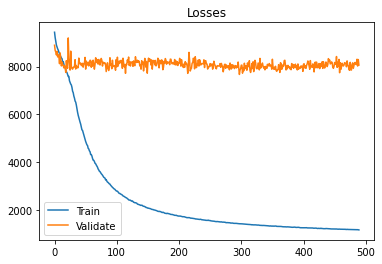

In [ ]:
plt.plot(t.loss_history['train'], label="Train")
plt.plot(t.loss_history['val'], label="Validate")
plt.title("Losses")
plt.legend()
plt.show()

In [ ]:
t.test()

Make sure you're using up to date model!!!
Colorizing /content/drive/My Drive/colorization/test using /content/drive/My Drive/colorization/model/colnet-the-best.pt

Resuming training of: /content/drive/My Drive/colorization/model/colnet-the-best.pt
Processing batch 1 / 10


Processing batch 2 / 10


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Processing batch 3 / 10


Processing batch 4 / 10


Processing batch 5 / 10


Processing batch 6 / 10


Processing batch 7 / 10


Processing batch 8 / 10


Processing batch 9 / 10


Processing batch 10 / 10


Saved all photos to /content/drive/My Drive/colorization/out
